In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set the device to be used for computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
#Sets the batch size used for training or inference.
batch_size = 32

In [4]:
# Define the transformation pipeline for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize image pixel values
])

# Load the training dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the testing dataset
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

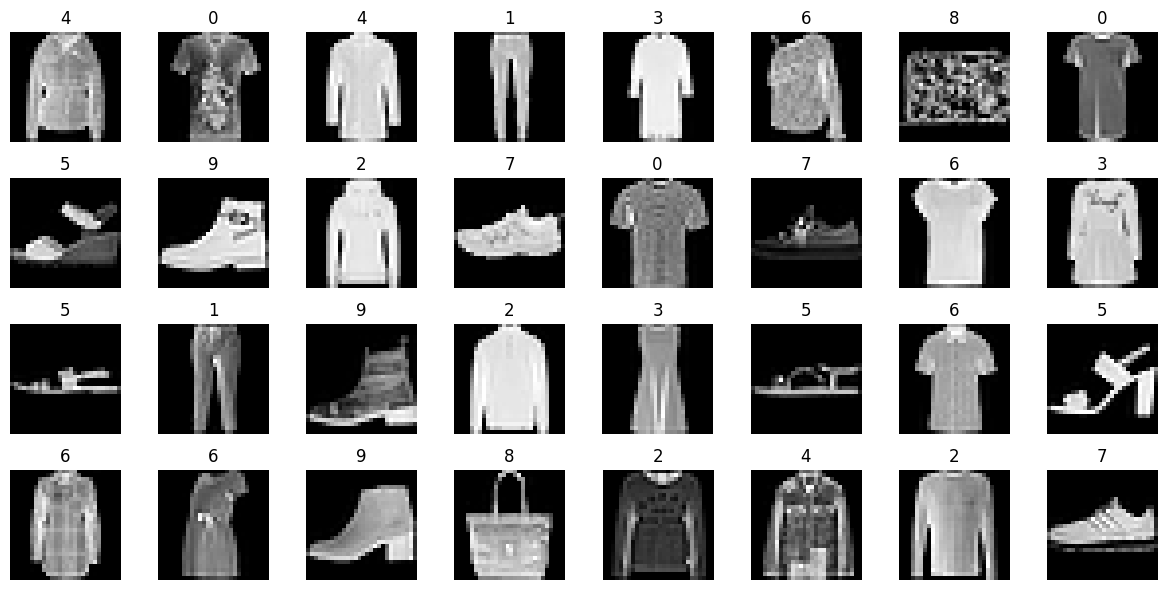

In [5]:
# Get a batch of images and labels from the trainloader
images, labels = next(iter(trainloader))

# Plot the images
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(images[i], (1, 2, 0)), cmap='gray')
    ax.axis('off')
    ax.set_title(str(labels[i].item()))

plt.tight_layout()
plt.show()

In [6]:
# Define the neural network architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 4) # 1 input image channel, 4 output channels, 4x4 square convolution kernel
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 160)  # 4*4 from image dimension
        self.fc2 = nn.Linear(160, 128) # an affine operation: y = Wx + b
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # If the size is a square you can only specify a single number
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Create an instance of the model
model = Net()

In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
# Move the model to the device
model.to(device)

# Train the model
n_epochs = 5
model.train()

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # Print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 1.466


In [ ]:
# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 83 %


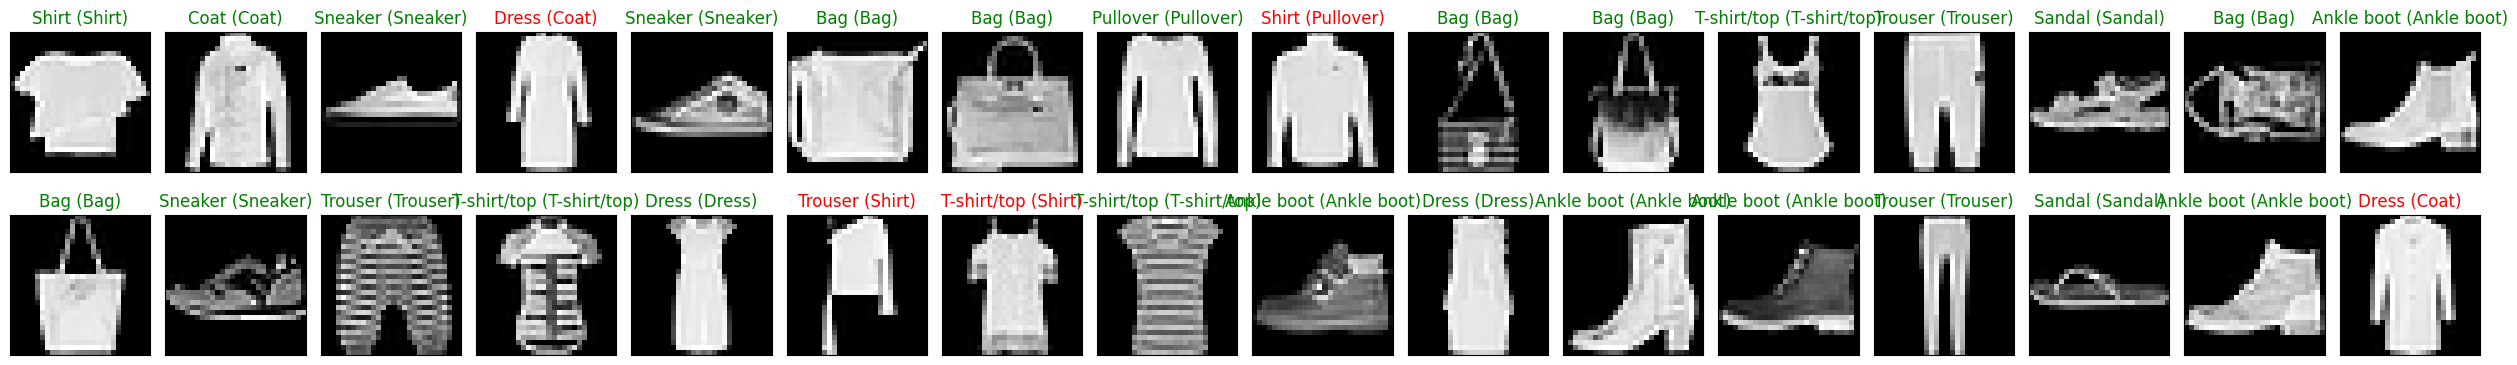

In [ ]:
import random

# Get a random batch of images and labels from the testloader
testloader_list = list(iter(testloader))
images, labels = random.choice(testloader_list)

# Move the images to the device
images = images.to(device)
labels = labels.to(device)

# Get the model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Define the class labels for FashionMNIST dataset
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot the images and their labels
fig = plt.figure(figsize=(25, 4))

# Get the number of images in the batch
num_images = images.shape[0]

for idx in np.arange(num_images):
    ax = fig.add_subplot(2, num_images//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)), cmap='gray')
    ax.set_title("{} ({})".format(class_labels[predicted[idx].item()], class_labels[labels[idx].item()]),
                 color=("green" if predicted[idx]==labels[idx] else "red"))

plt.tight_layout()
plt.show()